In [1]:
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import os

# Overview of the fit of base learners on the sum time series

In [6]:
def load_npy_files(folder_path):
    model_dict = {}
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        prediction = np.load(file_path)
        key = os.path.splitext(file_name)[0]
        model_dict[key] = prediction
    return model_dict

folder_path = "forecasts/base_learners_sum"
pred_dict = load_npy_files(folder_path)
true = np.load("true/sum.npy")
ts = np.load("true/ts.npy")

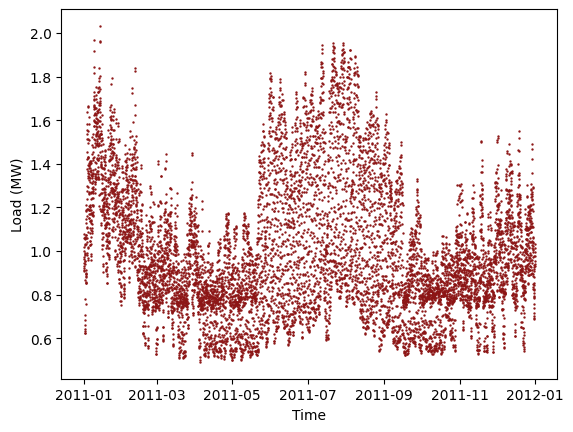

In [7]:
plt.scatter(ts, true, color='#8c1515', marker='o', s=0.5)
plt.xlabel('Time')
plt.ylabel('Load (MW)')
tick_values = np.arange(0.6e06, 2.1e6, 0.2e6)
plt.yticks(tick_values, [f'{val/1e6:.1f}' for val in tick_values])
plt.show()

In [8]:
def plot_dezoomed_comparison(pred_dict, true, ts):
    names_dict = {"historical_averages": "Historical Averages", "lightgbm": "LightGBM", "prophet": "Prophet", "SARIMA": "SARIMA"}
    colors_dict = {"historical_averages": "#8c1515", "lightgbm": "#15748c", "prophet": "#158c15", "SARIMA": "grey"}
    plt.scatter(ts, true, label='True load', color='black', marker='o', s=20)
    for model_name, pred_values in pred_dict.items():
        if model_name == "SARIMA":
            pred_values = pred_values[:-1]
        plt.plot(ts, pred_values, label=names_dict[model_name], color=colors_dict[model_name], linewidth=1)
    plt.xlabel('Time')
    tick_values = np.arange(0.4e06, 2.1e6, 0.2e6)
    plt.yticks(tick_values, [f'{val/1e6:.1f}' for val in tick_values])
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.show()

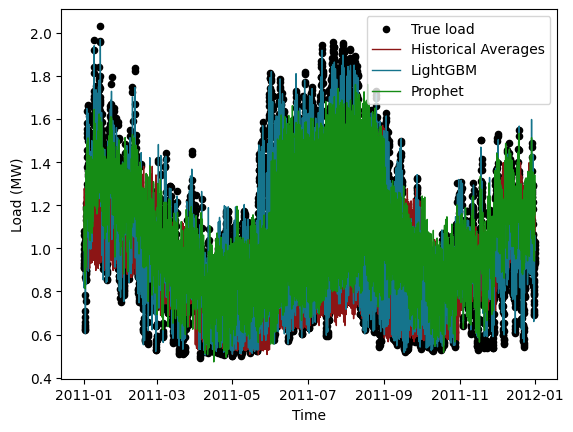

In [9]:
plot_dezoomed_comparison(pred_dict, true, ts)

In [155]:
def plot_zoomed_comparison(pred_dict, true, ts, date):
    names_dict = {"historical_averages": "Historical Averages", "lightgbm": "LightGBM", "prophet": "Prophet"}
    colors_dict = {"historical_averages": "#8c1515", "lightgbm": "#15748c", "prophet": "#158c15"}
    start_date = np.datetime64(dt.datetime(2011,date.month,date.day,0,0,0))
    end_date = np.datetime64(dt.datetime(2011,date.month,date.day,23,59,59))
    indices = np.where((ts >= start_date) & (ts < end_date))[0]

    plt.scatter(ts[indices], true[indices], label='True load', color='black', marker='o', s=20)
    for model_name, pred_values in pred_dict.items():
        plt.plot(ts[indices], pred_values[indices], color=colors_dict[model_name], label=names_dict[model_name])
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set the major locator to every 2 hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Time')
    tick_values = np.arange(1.0e06, 1.7e6, 0.1e6)
    plt.yticks(tick_values, [f'{val/1e6:.1f}' for val in tick_values])
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.show()

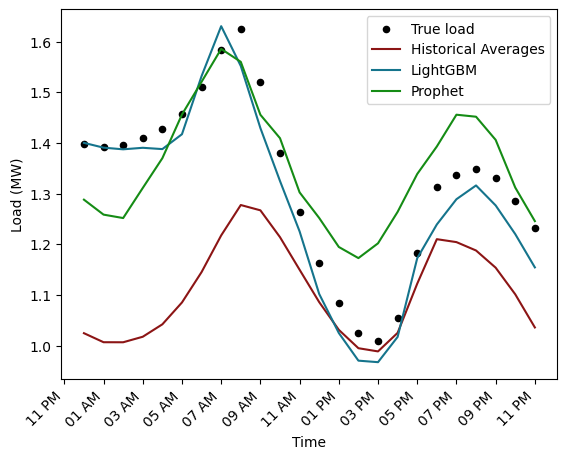

In [156]:
plot_zoomed_comparison(pred_dict, true, ts, dt.datetime(2011,1,15))

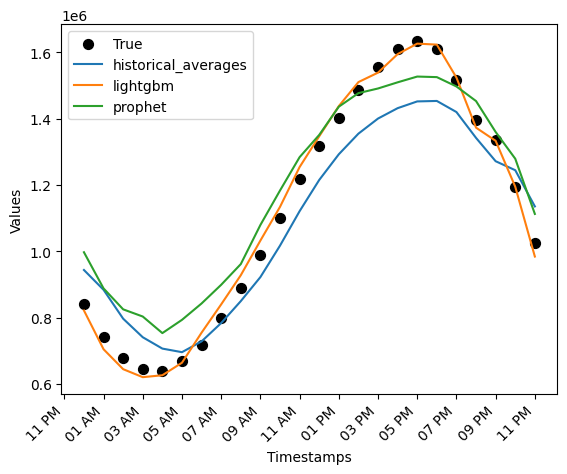

In [57]:
plot_zoomed_comparison(pred_dict, true, ts, dt.datetime(2011,7,1))

# Impact of hierarchical reconciliation

In [224]:
def zoomed_reconciliation(pred_dict, true_dict, ts, date):
    start_date = np.datetime64(dt.datetime(2011,date.month,date.day,0,0,0))
    end_date = np.datetime64(dt.datetime(2011,date.month,date.day,23,59,59))
    indices = np.where((ts >= start_date) & (ts < end_date))[0]
    true_names_dict = {"E004": "Master - True Load", "15": "Child - True Load"}
    true_colors = {"E004": "black", "15": "#001f3f"}
    forecasts_names_dict = {"unreconciled_15": "Child - Unreconclied", "reconciled_14": "Child - Reconciled",
                             "top_reconciled": "Master - Reconciled", "top_unreconciled": "Master - Unreconciled"}
    forecasts_colors = {"unreconciled_15": "#15748c", "reconciled_14": "#8c1515",
                             "top_reconciled": "#158c15", "top_unreconciled": "#8c5315"}

    for name, true_data in true_dict.items():
        if str(name) in ["15", "E004"]:
            plt.scatter(ts[indices], true_data[indices], label=true_names_dict[str(name)], marker='o', s=5, color=true_colors[str(name)])
    for model_name, pred_values in pred_dict.items():
        if model_name in ["top_reconciled", "top_unreconciled", "unreconciled_15", "reconciled_14"]:
            plt.plot(ts[indices], pred_values[indices], label=forecasts_names_dict[model_name], linewidth=2, color=forecasts_colors[model_name])
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set the major locator to every 2 hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamps')
    #plt.ylim([0,50000])
    tick_values = np.arange(40000, 141000, 20000)
    plt.yticks(tick_values, [f'{val/1e3:.0f}' for val in tick_values])
    plt.ylabel('Load (kW)')
    handles, labels = plt.gca().get_legend_handles_labels()
    custom_order = [0, 1, 3, 2, 4, 5]
    reordered_handles = [handles[i] for i in custom_order]
    reordered_labels = [labels[i] for i in custom_order]

    # Create a legend with the reordered handles and labels
    plt.legend(reordered_handles, reordered_labels)
    plt.show()

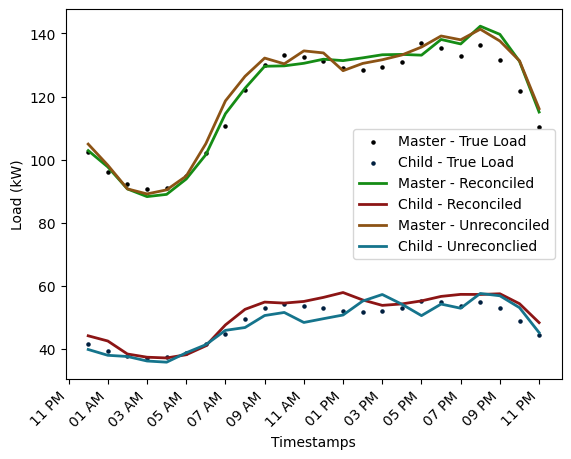

In [225]:
folder_path = "forecasts/reconciliation"
pred_dict = load_npy_files(folder_path)
true_dict = {"E004": np.load("true/true_E002.npy", allow_pickle=True), 14: np.load('true/true_14.npy', allow_pickle=True), 15: np.load('true/true_15.npy', allow_pickle=True), 428: np.load('true/true_428.npy', allow_pickle=True)}
zoomed_reconciliation(pred_dict, true_dict, ts, dt.datetime(2011,4,9))